## Visualizing crime statistics in LA

### Goal: 
To understand the crime landscape in LA by answering the following questions.
##### What are most recurring crimes in LA?
##### Is the police response a match for the criminal activity?
##### Does the LA police deparment seems to follow a strategy based on data to mitigate crime?

In [45]:
#We start by importing our dependencies
import pandas as pd
from help_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

In [2]:
# Loading csv files into dataframes
path = 'los-angeles-crime-arrest-data/'
cri = pd.read_csv(path + 'crime-data.csv', encoding='utf-8')
arr = pd.read_csv(path + 'arrest-data.csv', encoding='utf-8')

In [3]:
# Preparing date variables to be able to compare accross databases
cri = prepare_data(cri)
arr = prepare_data(arr)

/Users/AbreuLastra_Work/repos/crime_analysis/help_functions.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['week'] = df['date'].dt.strftime('%Y-w%U')
/Users/AbreuLastra_Work/repos/crime_analysis/help_functions.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['month'] = df['date'].dt.month
/Users/AbreuLastra_Work/repos/crime_analysis/help_functions.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

### 1. What are most recurring crimes in LA?
Let's start with question 1.

In [4]:
print('This analysis takes data from the LA Police department crimes reports from {}, until {}.'.format(cri.date.min(), cri.date.max()))
print('The final table contains {} cases.'.format(cri.shape[0]))
print('The LA police identifies in its database {} types of crimes.'.format(cri['Crime Code'].value_counts().shape[0]))

This analysis takes data from the LA Police department crimes reports from 2018-12-25 00:00:00, until 2019-06-22 00:00:00.
The final table contains 103181 cases.
The LA police identifies in its database 130 types of crimes.


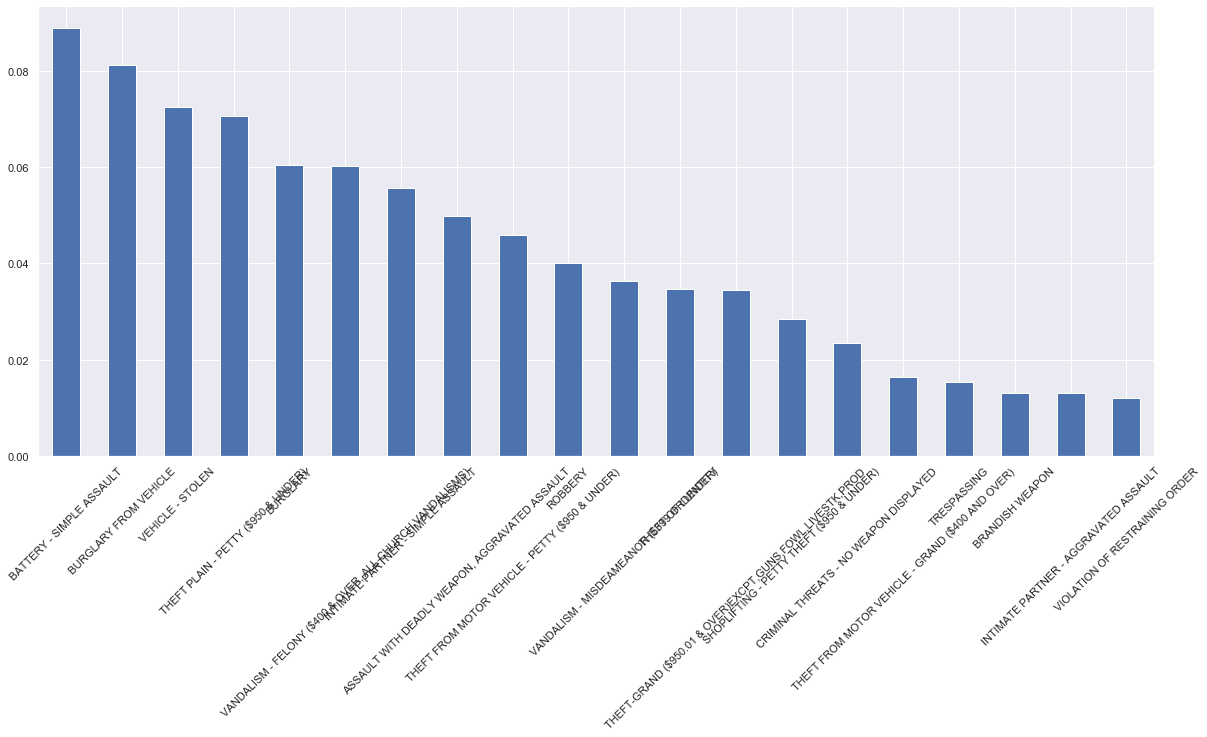

In [9]:
most_frequent_crimes = cri['Crime Code Description'].value_counts().head(20) / cri['Crime Code'].value_counts().sum()
chart = most_frequent_crimes.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

At first glance, the first hurdle to analyse paterns in crime is the high detail in the typification of crimes: 130 possible offences. As the previous graph shows, some crimes could be grouped together (like different types of burglaries and thefts). Currently, there is only one type of crime that accounts for more than 10% of the total incidents, and even this seems a bit too broad "Miscellaneous Other Violations".

Following an analysis of how the policie typifies crimes, I relabeled the crime description code, based on the variable 'Charge Group Description', from the arrests database. We could benefit in two ways from this: first, we would have broader categories for types of crimes, allowing us to identify the main problems in the city; second, we could have consistency across the crime and arrests database. 

The next graph is the same graph as above, but after relabeling the most recurrent crimes. 

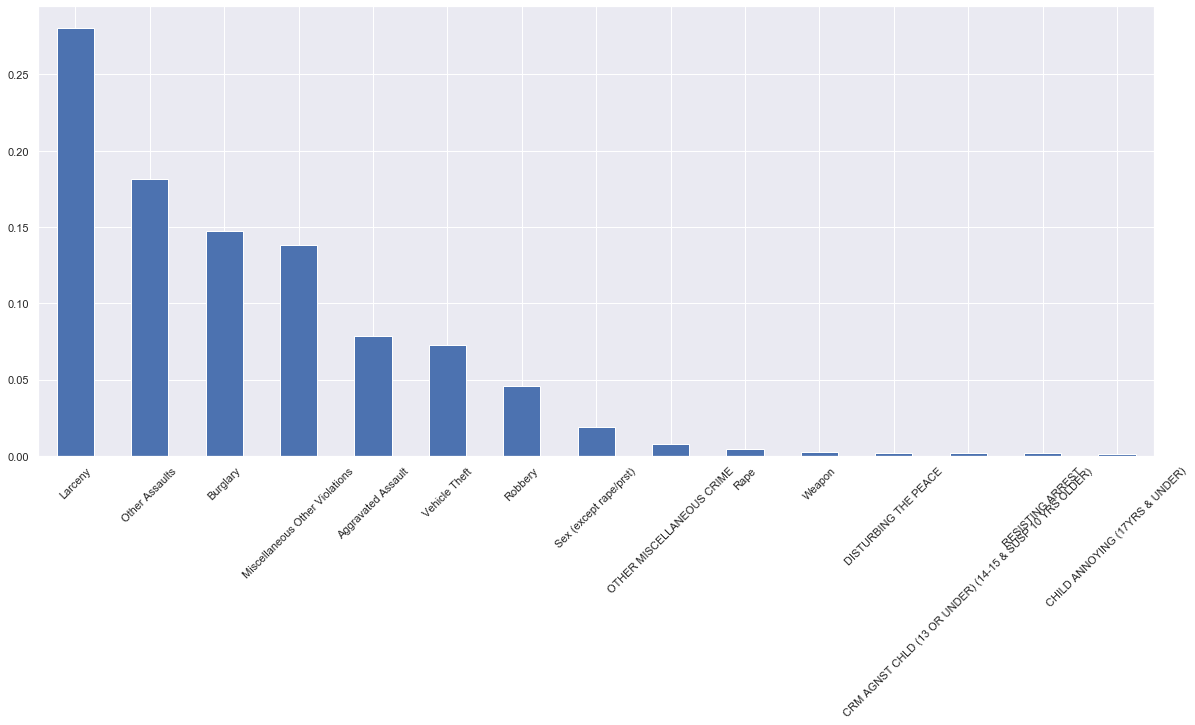

In [10]:
most_frequent_crimes = cri['crime_description_recoded'].value_counts().head(15) / cri['crime_description_recoded'].value_counts().sum()
chart = most_frequent_crimes.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

As we can see, when we regroup the crime descriptions, it becomes evident that there are six types of crimes that account for more than 80% of the criminal activity. In particular, larceny alone accounts for about a third of all crime. It's noteworthy that most of the thefts are non violent. Larceny implies the theft of property, but not directly from its owner; and burglary implies that somebody entered a building to take something, but again, they are not like robbery, which implies that somebody was taking from someone using force. [references: see here](https://www.criminaldefenselawyer.com/resources/criminal-defense/criminal-offense/differences-between-theft-burglary-robbery)

In [65]:
top_crimes = cri['crime_description_recoded'].value_counts().head(8).index

Let's take a look from another angle: the weekly pattern of criminal activity. Criminal activity, on average, seems to be almost evenly distributed throughout the week.  The day of the week is Sunday, and then it grows gradually, to hit a peak on fridays. Then saturday goes down again. 

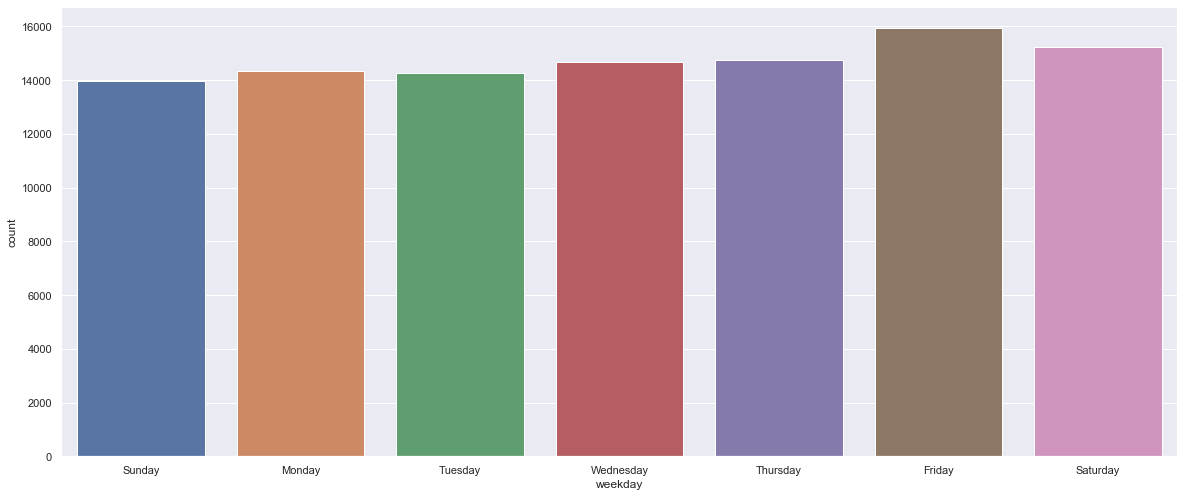

In [12]:
ax = sns.countplot(x="weekday", data=cri, order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

In [66]:
top_crimes

Index(['Larceny', 'Other Assaults', 'Burglary',
       'Miscellaneous Other Violations', 'Aggravated Assault', 'Vehicle Theft',
       'Robbery', 'Sex (except rape/prst)'],
      dtype='object')

When we limit the analysis by day of the week to the top six crimes, as defined above, there are some interesting findings. Friday is the top day for two of the most prevalent crimes: burglary and larceny. Without doing too much research, one could speculate that this is the day of the week that most people go out for dinner or entertainment, living their homes unattended, and are probably less careful about their belongings. For aggravated and other types of assault, perhaps the most worrysome crime in this bundle because it implies violence, the peak occurs on weekends both saturday and sunday. 

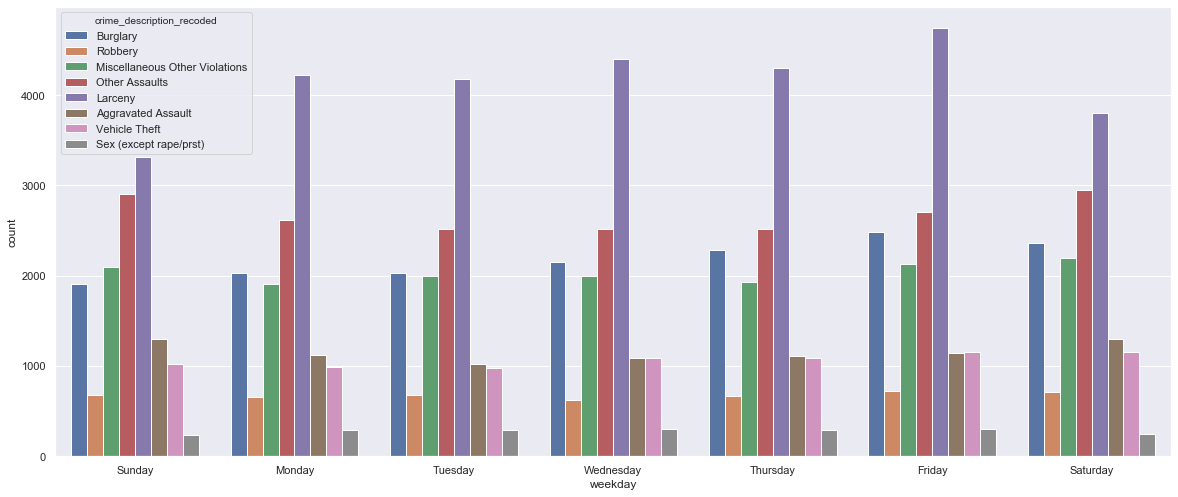

In [100]:
ax = sns.countplot(x="weekday", data=cri[cri['crime_description_recoded'].isin(top_crimes)], hue = 'crime_description_recoded', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

To answer question 1 (**What are most recurring crimes in LA?**): The most reccurent crime in LA is burglary, with more than 36 thousand cases every six months. Along with assaults, and burglaries, they account for moe than 70% of the criminal activity. As we can see, these crimes share in common that they show an even distritution during the weekd days, and an increase toward the weekend. Activities related to stealing property, like burglary and larceny, reak a peak on fridays; assaults, aggravated and other types, occur more often on Saturdays and Sundays. 

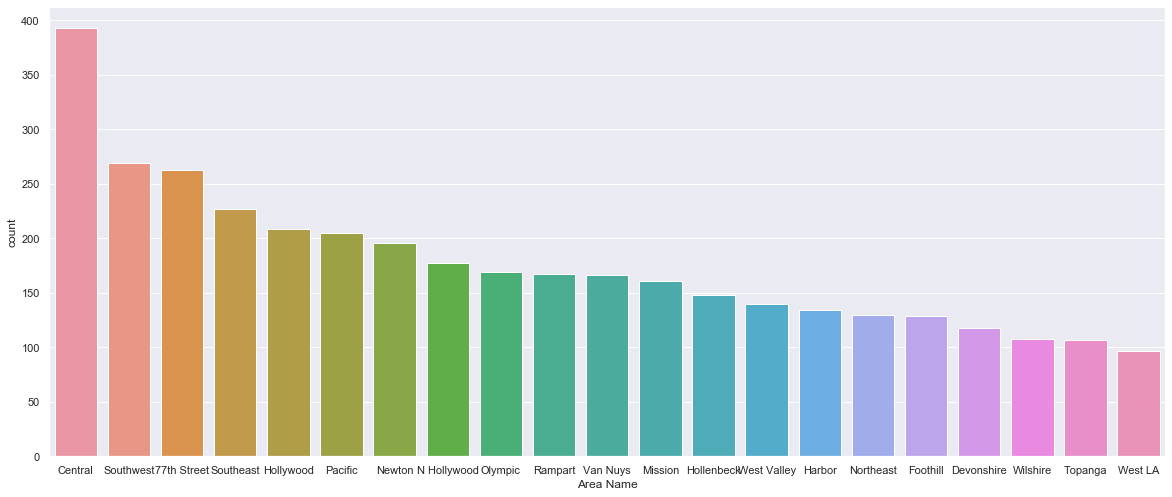

In [87]:
data = arr[arr['Charge Group Description']=='Other Assaults']#'Aggravated Assault']
ax = sns.countplot(x='Area Name', data= data, order = data['Area Name'].value_counts().index)

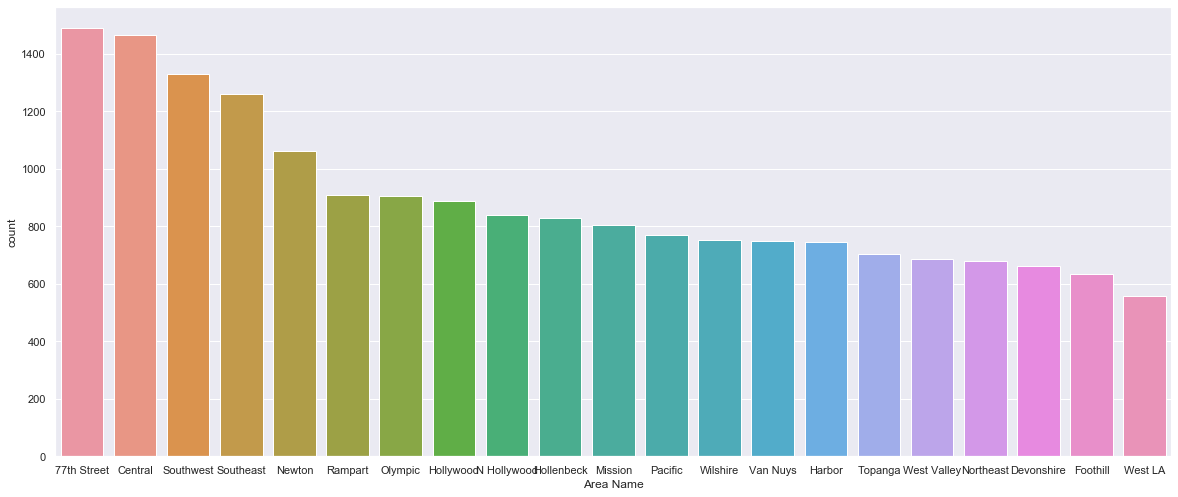

In [88]:
data = cri[cri['crime_description_recoded']=='Other Assaults']#Aggravated Assault']
ax = sns.countplot(x='Area Name', data= data, order = data['Area Name'].value_counts().index)

### Is the police response a match for the criminal activity?


In [89]:
arr_cri_ratio = arr.shape[0]/cri.shape[0]
print('This analysis takes data from the LA Police department arrests reports from {}, until {}.'.format(arr.date.min(), arr.date.max()))
print('The final table contains {} cases. Namely, the ratio of arrests to crimes reported is {}.'.format(arr.shape[0], arr_cri_ratio))
print('The LA police identifies in its database {} types of charge groups, and {} types of charges.'.format(arr['Charge Group Description'].value_counts().shape[0], arr['Charge Description'].value_counts().shape[0]))


This analysis takes data from the LA Police department arrests reports from 2018-12-25 00:00:00, until 2019-06-22 00:00:00.
The final table contains 40884 cases. Namely, the ratio of arrests to crimes reported is 0.39623574107636095.
The LA police identifies in its database 27 types of charge groups, and 835 types of charges.


So, about for every two reported crimes, there isapproximately one arrest. Initially, it can be assumed that multiple reports could be linked to one case, so this number might not be labeled as 'low'. Let's turn to see if what are the most types of arrest.

In [90]:
top_arrests = arr['Charge Group Description'].value_counts().head(6).index

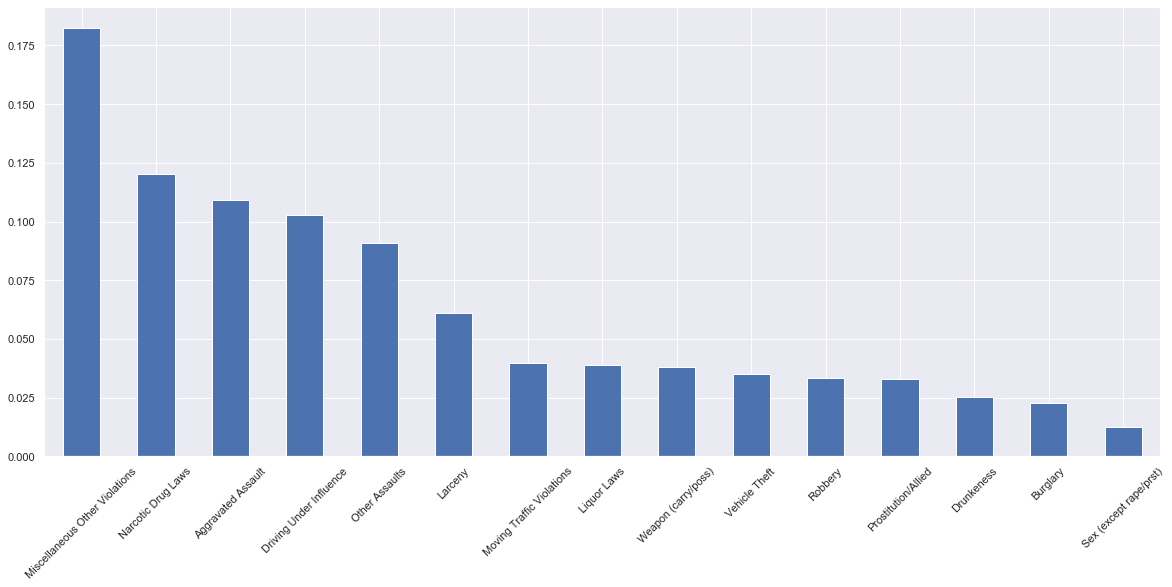

In [91]:
most_frequent_arrests = arr['Charge Group Description'].value_counts().head(15) / arr['Charge Group Description'].value_counts().sum()
chart = most_frequent_arrests.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

The most frequent type of arrest goes to the group "Miscellaneous Other Violations", with 17% of the cases. This category includes parole violations, failure to pay, and vandalism. Next are "Narcotic Drug Laws", "Aggravated Assault", "Driving Under Influence" and "Other assaults. From the top five charge group descriptions, two overlap with most frequent type of crimes: both types of assaults. Larceny, which is the top crime, represents less than 7% of arrests.

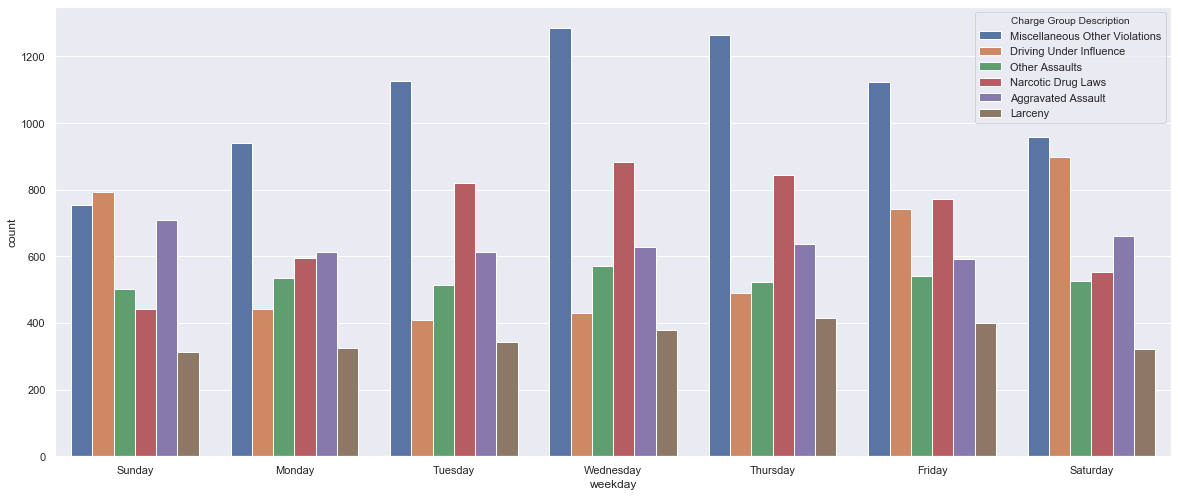

In [92]:
ax = sns.countplot(x="weekday", data=arr[arr['Charge Group Description'].isin(top_arrests)], hue = 'Charge Group Description', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])



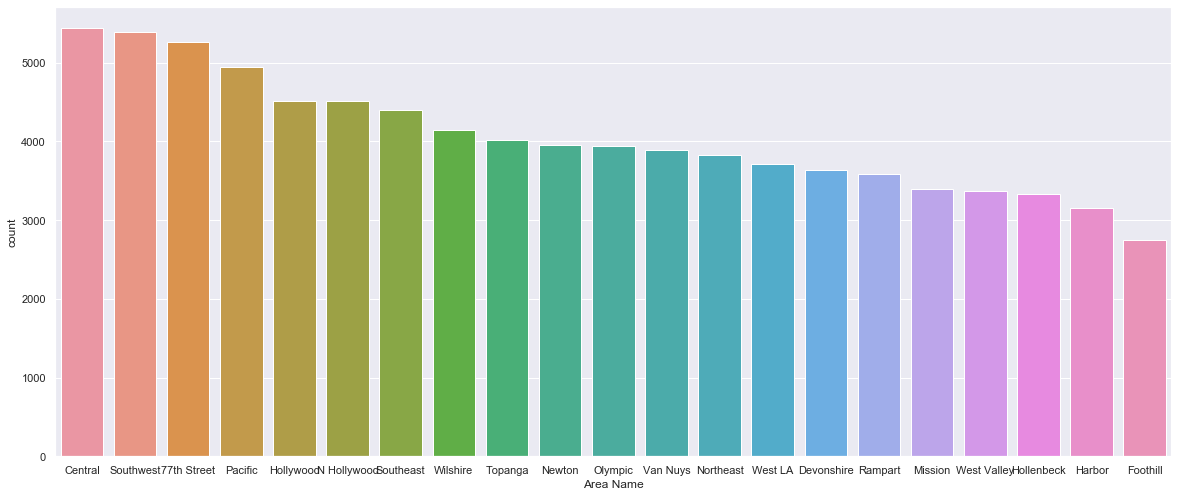

In [20]:
data = cri[cri['crime_description_recoded'].isin(top_crimes)]
ax = sns.countplot(x='Area Name', data= data, order = data['Area Name'].value_counts().index)

In [76]:
cri['Crime Code Description'].value_counts()

Miscellaneous Other Violations                              13671
BATTERY - SIMPLE ASSAULT                                     9184
BURGLARY FROM VEHICLE                                        8392
VEHICLE - STOLEN                                             7487
THEFT PLAIN - PETTY ($950 & UNDER)                           7289
BURGLARY                                                     6232
INTIMATE PARTNER - SIMPLE ASSAULT                            5735
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               5144
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              4747
ROBBERY                                                      4129
THEFT OF IDENTITY                                            3571
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     3555
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     2932
CRIMINAL THREATS - NO WEAPON DISPLAYED                       2426
THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)             1696
BRANDISH W

In [93]:
arr.columns

Index(['Report ID', 'Arrest Date', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)', 'date', 'week', 'month', 'weekday',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_12', '77th Street', 'Central', 'Devonshire',
       'Foothill', 'Harbor', 'Hollenbeck', 'Hollywood', 'Mission',
       'N Hollywood', 'Newton', 'Northeast', 'Olympic', 'Pacific', 'Rampart',
       'Southeast', 'Southwest', 'Topanga', 'Van Nuys', 'West LA',
       'West Valley', 'Wilshire'],
      dtype='object')

In [94]:
# creating a table of incidents per day
table_week = pd.DataFrame()
table_week['crime'] = cri.groupby('week').size()
table_week['arrests'] = arr.groupby('week').size()

In [36]:
cri.columns

Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location ', 'date', 'week',
       'weekday'],
      dtype='object')

In [ ]:
cri['Status Description'].value_counts() /cri['Status Description'].value_counts().sum()

In [55]:
cri[['Date Reported','Date Occurred', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4']].tail()

,Date Reported,Date Occurred,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4
1993254,6242019-01-01T00:00:00,2019-06-21T00:00:00,X,404.0,DEPARTMENT STORE,NaN,NaN,IC,Invest Cont,442.0,NaN,NaN,NaN
1993255,1152019-01-01T00:00:00,2019-01-15T00:00:00,H,101.0,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,910.0,NaN,NaN,NaN
1993256,2022019-01-01T00:00:00,2019-02-01T00:00:00,X,101.0,STREET,NaN,NaN,IC,Invest Cont,946.0,998.0,NaN,NaN
1993257,4262019-01-01T00:00:00,2019-02-05T00:00:00,NaN,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN
1993258,4262019-01-01T00:00:00,2019-01-07T00:00:00,NaN,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN


In [18]:
cri['Crime Code Description'].value_counts().head() / float(cri['Crime Code Description'].value_counts().sum())


AttributeError: 'int' object has no attribute 'head'

In [16]:
cri['Crime Code Description'].value_counts().head(10)

BATTERY - SIMPLE ASSAULT                                   9184
BURGLARY FROM VEHICLE                                      8392
VEHICLE - STOLEN                                           7487
THEFT PLAIN - PETTY ($950 & UNDER)                         7289
BURGLARY                                                   6232
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    6226
INTIMATE PARTNER - SIMPLE ASSAULT                          5735
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             5144
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            4747
ROBBERY                                                    4129
Name: Crime Code Description, dtype: int64

In [22]:
arr['Charge Description'].value_counts().head(10)

DRUNK DRIVING ALCOHOL/DRUGS                 95410
DRINKING IN PUBLIC                          92965
CORPORAL INJURY ON SPOUSE/COHABITANT/ETC    44812
POSSESSION CONTROLLED SUBSTANCE             43697
FTA AFTER WRITTEN PROMISE                   31177
POSSESSION NARCOTIC CONTROLLED SUBSTANCE    29352
PROSTITUTION                                26169
OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE     25668
SIT/LIE/SLEEP SIDEWALK OR STREET            25573
LOS ANGELES MUNICIPAL CODE                  24367
Name: Charge Description, dtype: int64

In [29]:
arr.columns

Index(['Report ID', 'Arrest Date', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [31]:
arr[['Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description','LA Specific Plans']].head()

,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,LA Specific Plans
0,M,W,24.0,Miscellaneous Other Violations,M,594(A)PC,VANDALISM,10.0
1,M,O,NaN,NaN,O,300(B)WIC,NaN,NaN
2,F,O,22.0,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,17.0
3,F,W,22.0,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,NaN
4,M,W,8.0,Other Assaults,F,69PC,OBSTRUCT/RESIST EXECUTIVE OFFICER,10.0


In [121]:
cri.columns

Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')

In [9]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [21]:
arr['Arrest Type Code'].value_counts() / arr.shape[0]

M    0.535906
F    0.410185
O    0.025658
I    0.024851
D    0.003400
Name: Arrest Type Code, dtype: float64

In [17]:
arr['br'] = arr['Charge Description'].str.contains('|'.join(['BRANDISH']))

In [18]:
arr[arr['br']==1][['Charge Description', 'Charge Group Description']]

,Charge Description,Charge Group Description
41364,BRANDISH F/ARM REPLICA AT OCCUPANT OF VEH,Aggravated Assault
41399,BRANDISH F/ARM REPLICA AT OCCUPANT OF VEH,Aggravated Assault


In [39]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [8]:
cri.columns


Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location ', 'date'],
      dtype='object')

In [19]:
arr.head()

,Unnamed: 0,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),date,week,weekday
0,0,5666847,2019-06-22,1630.0,14,Pacific,1457,44,M,W,...,"{'latitude': '33.992', 'human_address': '{""add...",24031.0,918.0,1137.0,10.0,10.0,85.0,2019-06-22,2019-w24,Saturday
1,1,5666688,2019-06-22,1010.0,10,West Valley,1061,8,M,O,...,"{'latitude': '34.1687', 'human_address': '{""ad...",19339.0,321.0,1494.0,NaN,4.0,10.0,2019-06-22,2019-w24,Saturday
2,2,5666570,2019-06-22,400.0,15,N Hollywood,1543,31,F,O,...,"{'latitude': '34.1649', 'human_address': '{""ad...",8890.0,205.0,1332.0,17.0,5.0,39.0,2019-06-22,2019-w24,Saturday
3,3,5666529,2019-06-22,302.0,17,Devonshire,1738,23,F,W,...,"{'latitude': '34.2692', 'human_address': '{""ad...",19329.0,69.0,388.0,NaN,2.0,78.0,2019-06-22,2019-w24,Saturday
4,4,5666742,2019-06-22,1240.0,14,Pacific,1472,28,M,W,...,"{'latitude': '33.9609', 'human_address': '{""ad...",25075.0,937.0,241.0,10.0,10.0,16.0,2019-06-22,2019-w24,Saturday


In [46]:
arr[arr['Charge Group Description']=='Aggravated Assault']['Charge Description'].value_counts()

CORPORAL INJURY ON SPOUSE/COHABITANT/ETC     2227
ADW, NOT FIREARM, W/GBI                      1191
ASSAULT LIKELY TO PRODUCE GBI                 187
ADW W/FIREARM                                 173
BATTERY W/GBI                                 135
ATTEMPT - MURDER                              129
INJURING A SPOUSE/COHABITANT, ETC W/PRIOR      88
CRUEL TO CHILD LIKELY TO PROD GBI/DEATH        50
CAUSE HARM/DEATH OF ELDER/DEPEND ADULT         40
ADW PO/FIREMAN W/O FIREARM/GBI                 35
ADW W/O FIREARM/GBI                            27
ADW W/SEMIAUTOMATIC RIFLE                      23
THROW SUBSTANCE AT VEHICLE W/GBI INTENT        23
ARSON INHABITED STRUCTURE/PROPERTY             22
BATT ON SCHL EMPLOYEE/RETALIATION W/INJ        17
MAYHEM                                         15
DRAW/EXHIBIT IMITATION FIREARM                 12
EXHIBIT/DRAW FIREARM                           10
CORPORAL INJURY ON CHILD                        9
INFLICT BODILY HARM/DEATH ON ELDER ADULT        6


In [95]:
arrests = arr[arr['Charge Group Description'].isin(top_crimes)]['Charge Group Description'].value_counts().sort_index()

In [96]:
crimes = cri[cri['crime_description_recoded'].isin(top_crimes)]['crime_description_recoded'].value_counts().sort_index()

In [97]:
crimes


Aggravated Assault                 8076
Burglary                          15237
Larceny                           28952
Miscellaneous Other Violations    14239
Other Assaults                    18718
Robbery                            4727
Sex (except rape/prst)             1964
Vehicle Theft                      7487
Name: crime_description_recoded, dtype: int64

In [98]:
ratio = arrests/crimes

In [99]:
ratio.sort_values(ascending=False)

Aggravated Assault                0.551511
Miscellaneous Other Violations    0.523000
Robbery                           0.286440
Sex (except rape/prst)            0.255601
Other Assaults                    0.198365
Vehicle Theft                     0.192066
Larceny                           0.086177
Burglary                          0.060314
dtype: float64

In [72]:
cri['crime_description_recoded'].value_counts() / cri['crime_description_recoded'].shape[0]

Larceny                                                     0.280594
Other Assaults                                              0.181409
Burglary                                                    0.147673
Miscellaneous Other Violations                              0.138000
Aggravated Assault                                          0.078270
Vehicle Theft                                               0.072562
Robbery                                                     0.045813
Sex (except rape/prst)                                      0.019035
OTHER MISCELLANEOUS CRIME                                   0.007908
Rape                                                        0.004235
Weapon                                                      0.002268
DISTURBING THE PEACE                                        0.001832
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)    0.001774
RESISTING ARREST                                            0.001599
CHILD ANNOYING (17YRS & UNDER)    

In [5]:
arr = arr.dropna(subset=['Charge Description'])

In [17]:
arr[arr['Charge Description'].str.contains('DISTURBING THE PEACE')][['Charge Group Description', 'Charge Description']]

,Charge Group Description,Charge Description
33229,Disturbing the Peace,DISTURBING THE PEACE


In [29]:
cri.columns

Index([               'Unnamed: 0',                 'DR Number',
                   'Date Reported',             'Date Occurred',
                   'Time Occurred',                   'Area ID',
                       'Area Name',        'Reporting District',
                      'Crime Code',    'Crime Code Description',
                        'MO Codes',                'Victim Age',
                      'Victim Sex',            'Victim Descent',
                    'Premise Code',       'Premise Description',
                'Weapon Used Code',        'Weapon Description',
                     'Status Code',        'Status Description',
                    'Crime Code 1',              'Crime Code 2',
                    'Crime Code 3',              'Crime Code 4',
                         'Address',              'Cross Street',
                       'Location ',                      'date',
       'crime_description_recoded',                   'larceny',
                       'c

In [34]:
cri['victim_female']=[1 if x == 'F' else 0 for x in cri['Victim Sex']]

In [40]:
cri['Victim Age'].isnull().mean()

0.0

In [41]:
cri['Victim Age'].value_counts() / cri.shape[0]

0     0.193379
29    0.023880
26    0.022979
27    0.022931
30    0.022727
28    0.022485
25    0.021777
35    0.021768
31    0.021419
32    0.020469
33    0.020159
24    0.020072
34    0.019907
23    0.018957
36    0.018172
22    0.017571
37    0.017445
38    0.017338
18    0.016621
40    0.016398
50    0.016146
39    0.016117
21    0.015478
41    0.014954
42    0.014295
20    0.013898
43    0.013791
48    0.013753
44    0.013462
47    0.013268
        ...   
79    0.001463
80    0.001279
81    0.001231
9     0.001163
10    0.001105
82    0.001056
83    0.000989
4     0.000737
85    0.000678
86    0.000669
6     0.000649
8     0.000620
7     0.000611
99    0.000611
84    0.000572
5     0.000552
89    0.000533
3     0.000485
2     0.000436
88    0.000426
87    0.000407
90    0.000359
93    0.000281
92    0.000252
91    0.000223
95    0.000145
94    0.000145
96    0.000107
97    0.000058
98    0.000058
Name: Victim Age, Length: 99, dtype: float64

In [74]:
cri_pca = cri[cri['crime_description_recoded'].isin(top_crimes)].drop(columns = ['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'crime_description_recoded','date', 'Location ', 'week', 'weekday', 'month'])

In [76]:
# Second, we fit feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(cri_pca)
scaled_df = pd.DataFrame(scaler.transform(cri_pca), columns = cri_pca.columns)

In [77]:
# Apply PCA to the data.
pca = PCA(int(scaled_df.shape[1]*.5))
X_pca = pca.fit_transform(scaled_df)

In [78]:
# I'm using the scree_plot function from the helpers_functions.py file from the udacity notebook

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

0.6341998792888022

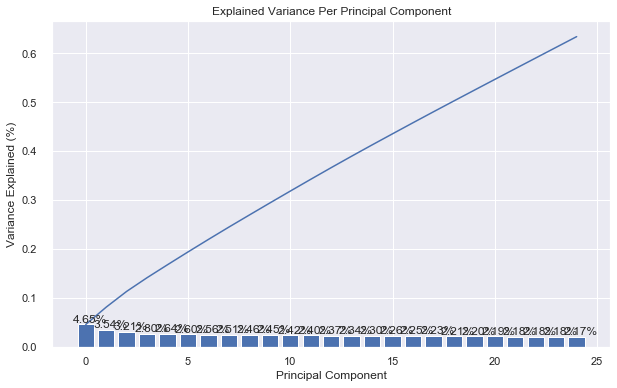

In [79]:
import numpy as np
# Investigate the variance accounted for by each principal component.
scree_plot(pca)
pca.explained_variance_ratio_.sum()

In [80]:
pca.explained_variance_ratio_

array([0.04650534, 0.03540061, 0.0321498 , 0.02801818, 0.02646417,
       0.02607446, 0.02560968, 0.02516894, 0.02465354, 0.02451537,
       0.02427616, 0.02407659, 0.02378994, 0.02340627, 0.02301776,
       0.02269279, 0.02258658, 0.02235008, 0.02214073, 0.02202528,
       0.02195875, 0.02189139, 0.02183277, 0.02181693, 0.02177776])

In [81]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# 
#dimensions = dimensions = ['dim_{}'.format(i) for i in range(1,len(pca.components_)+1)]

def see_component(pca,df, comp):
    dimensions = dimensions = [i for i in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(pca.components_, columns = df.keys())
    components.index = dimensions

    print(components.loc[comp].sort_values().head(10))
    print(components.loc[comp].sort_values().tail(10))

see_component(pca, scaled_df, 1)

larceny        -0.472243
car_theft      -0.319334
victim_white   -0.206941
Pacific        -0.098161
West LA        -0.090532
Topanga        -0.066746
N Hollywood    -0.057736
burglary       -0.056408
Devonshire     -0.055868
Northeast      -0.049366
Name: 1, dtype: float64
Southwest             0.066917
Newton                0.069881
sex                   0.070035
Southeast             0.117231
77th Street           0.129713
victim_black          0.226770
victim_female         0.247756
victim_hispanic       0.309905
aggravated_assault    0.326549
other_assault         0.459590
Name: 1, dtype: float64


In [82]:
see_component(pca, scaled_df, 2)

car_theft            -0.413103
larceny              -0.354406
victim_hispanic      -0.160200
77th Street          -0.140438
Newton               -0.136239
Southeast            -0.126722
Hollenbeck           -0.098676
Mission              -0.097576
aggravated_assault   -0.096699
Southwest            -0.085327
Name: 2, dtype: float64
West Valley      0.092192
Topanga          0.092462
Hollywood        0.104145
Wilshire         0.104807
Pacific          0.115619
violation        0.148650
West LA          0.162289
victim_female    0.186816
burglary         0.407860
victim_white     0.496496
Name: 2, dtype: float64


In [84]:
see_component(pca, scaled_df, 3)

victim_hispanic   -0.545996
Hollenbeck        -0.207402
violation         -0.200758
Mission           -0.195838
Foothill          -0.132883
Newton            -0.124739
Rampart           -0.106194
robbery           -0.082360
Northeast         -0.072003
Olympic           -0.069003
Name: 3, dtype: float64
Pacific               0.081616
larceny               0.092262
victim_white          0.101638
Central               0.109984
Southeast             0.121491
other_assault         0.144083
aggravated_assault    0.154816
Southwest             0.182839
77th Street           0.231363
victim_black          0.552752
Name: 3, dtype: float64


In [85]:
arr.columns

Index(['Report ID', 'Arrest Date', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)', 'date', 'week', 'month', 'weekday',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_12', '77th Street', 'Central', 'Devonshire',
       'Foothill', 'Harbor', 'Hollenbeck', 'Hollywood', 'Mission',
       'N Hollywood', 'Newton', 'Northeast', 'Olympic', 'Pacific', 'Rampart',
       'Southeast', 'Southwest', 'Topanga', 'Van Nuys', 'West LA',
       'West Valley', 'Wilshire'],
      dtype='object')

In [ ]:
arr_pca = cri.drop(columns = ['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'crime_description_recoded','date', 'Location ', 'week', 'weekday', 'month'])

In [ ]:
kohonen maps, discriminant functions